In [1]:
%load_ext Cython
from scipy import integrate
from scipy import interpolate
from scipy.interpolate import RectBivariateSpline
from scipy import optimize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import dill
sns.set()

In [2]:
%%cython 
import numpy as np
cimport numpy as np
from scipy import integrate
import time
from libc.math cimport exp
from libc.math cimport sqrt

DTYPE = np.float
ctypedef np.float_t DTYPE_t

from species import species_dict, _normalize_species
for pid in species_dict.keys():
    particle = species_dict[pid]
    particle['sign'] = 1. if particle['boson'] else -1.

#physical constants, units...
cdef float hbarc = 0.197 # GeV * fm

############################
########USER OPTIONS########
chosen_particles = [111, 211, 2212, 321] #particles included in thermodynamic quantities

#Grid parameters
cdef int npts_beta = 100 #size of grid in beta 
cdef int npts_rho = 150 #size of grid in rho 

cdef float T_eff_max_GeV = 0.2
cdef float T_eff_min_GeV = 0.1

#|lambda| <= |beta|
#so define rho by lambda = rho * beta, with rho in [-1, 1]
cdef float rho_min = -0.95
cdef float rho_max = 0.95
############################
########USER OPTIONS########

cdef float T_eff_max_fm = T_eff_max_GeV / hbarc #fm^-1
cdef float T_eff_min_fm = T_eff_min_GeV / hbarc #fm^-1

cdef float beta_min = 1. / T_eff_max_fm #fm
cdef float beta_max = 1. / T_eff_min_fm #fm
beta_grid = np.linspace(beta_min, beta_max, npts_beta)

rho_grid = np.linspace(rho_min, rho_max, npts_rho)

# The Max. Entropy Distribution Function
cdef float f_dist(float E, float beta, float rho, float m, float sign):
    cdef float E2, m2, lambdapi, arg
    E2 = E*E
    m2 = m*m
    lambdapi = rho*beta
    arg = E * ( beta + lambdapi*(1. - m2/E2) )
    return 1./(exp(arg) - sign)

# The Equil. Distribution Function
cdef float f_eq(float E, float beta_eq, float sign):
    cdef arg
    arg = beta_eq * E
    return 1./(exp(arg) - sign)

cdef float eps_integrand(float E, float beta, float rho, float m, float sign):
    cdef float E2, m2, lambdapi, num_factor
    E2 = E*E
    m2 = m*m
    #lambdapi = rho*beta
    num_factor = (4 * np.pi) / (2. * np.pi)**3.
    return num_factor * E2 * sqrt(E2 - m2) * f_dist(E, beta, rho, m, sign)
    
cdef float eps(float beta, float rho, float m, float sign):
    cdef val, err
    val, err = integrate.quad(eps_integrand, m, np.inf, args=(beta, rho, m, sign))
    return val

cdef float P_integrand(float E, float beta, float rho, float m, float sign):
    cdef float E2, m2, num_factor
    E2 = E*E
    m2 = m*m
    #lambdapi = rho*beta
    num_factor = (4 * np.pi) / (2. * np.pi)**3. / 3.
    return num_factor * (E2 - m2)**(1.5) * f_dist(E, beta, rho, m, sign)
    
cdef float P(float beta, float rho, float m, float sign):
    cdef float val, err
    val, err = integrate.quad(P_integrand, m, np.inf, args=(beta, rho, m, sign))
    return val


#Calculate the grid
recalculate_e_P = True

cdef np.ndarray eps_grid = np.zeros((npts_beta, npts_rho), dtype=DTYPE)
cdef np.ndarray P_grid = np.zeros((npts_beta, npts_rho), dtype=DTYPE)
cdef np.ndarray eq_eps_grid = np.zeros(npts_beta, dtype=DTYPE)

cdef float m, sign, degen, has_anti
cdef float beta, rho
cdef int ibeta, irho

t1 = time.time()
if recalculate_e_P:
    for ibeta, beta in enumerate(beta_grid):
        for irho, rho in enumerate(rho_grid):
            #for pid in species_dict.keys(): #sum over species
            for pid in chosen_particles: #sum over species
                has_anti = 2. if species_dict[pid]['has_anti'] else 1.
                m = species_dict[pid]['mass']
                sign = species_dict[pid]['sign']
                degen = species_dict[pid]['degen']
                
                prefac = has_anti * degen
                
                eps_grid[ibeta, irho] += prefac * eps(beta, rho, m, sign)
                P_grid[ibeta, irho] += prefac * P(beta, rho, m, sign)
                eq_eps_grid[ibeta] += prefac * eps(beta, 0.0, m, sign)
        
    np.savetxt("grids/eps.dat", eps_grid)
    np.savetxt("grids/P.dat", P_grid)
    np.savetxt("grids/eq_eps.dat", eq_eps_grid)
t2 = time.time()

/Users/derek/miniconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/Users/derek/miniconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


In [3]:
print("Time elapsed : " + str(t2-t1) + " sec")

Time elapsed : 25.492184162139893 sec


## These cells build the grid of energy density and pressure which we will interpolate
They take a while to run. Unless we need to change the particle/grid options, we can just load the grid from disk

In [4]:
#load the pre-calculated grid
eps_grid = np.loadtxt("grids/eps.dat")
P_grid = np.loadtxt("grids/P.dat")
eq_eps_grid = np.loadtxt("grids/eq_eps.dat")

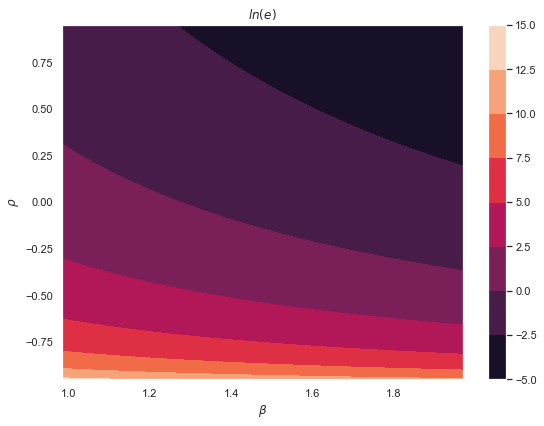

In [5]:
xx, yy = np.meshgrid(beta_grid, rho_grid)
fig, axes = plt.subplots(1, 1, figsize=(8,6))
plt.contourf(xx, yy, np.log(eps_grid.T) )
plt.xlabel(r"$\beta$")
plt.ylabel(r"$\rho$")
plt.title(r"$ln(e)$")
plt.colorbar()
plt.tight_layout(True)
plt.show()

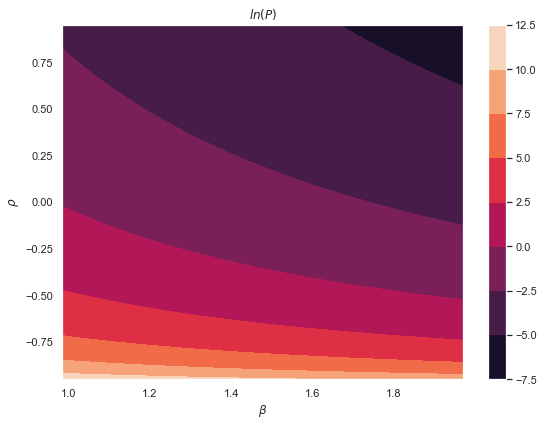

In [6]:
xx, yy = np.meshgrid(beta_grid, rho_grid)
fig, axes = plt.subplots(1, 1, figsize=(8,6))
plt.contourf(xx, yy, np.log(P_grid.T) )
plt.xlabel(r"$\beta$")
plt.ylabel(r"$\rho$")
plt.title(r"$ln(P)$")
plt.colorbar()
plt.tight_layout(True)
plt.show()

In [7]:
#creating interpolations of the energy density e(beta, lambda) 
#and total pressure P(beta, lambda)
ln_eps_interp = RectBivariateSpline(beta_grid, rho_grid, np.log(eps_grid) )
ln_P_interp = RectBivariateSpline(beta_grid, rho_grid, np.log(P_grid) )
ln_eq_eps_interp = interpolate.interp1d(np.log(eq_eps_grid), beta_grid )

In [8]:
#true values of beta and rho
beta_true = 1.
rho_true = -0.1

#the values of energy density and total pressure are given
ln_e0 = ln_eps_interp(beta_true, rho_true).flatten()[0] 
ln_P0 = ln_P_interp(beta_true, rho_true).flatten()[0] 

#find the equilibrium temp.
#beta_eq = ln_eq_eps_interp(ln_e0)

print("ln_e0 = " + str(ln_e0) + ", ln_P0 = " + str(ln_P0))

def my_fun(x):
    """input is vector with x[0] = beta, x[1] = rho"""
    ln_eps_func = ln_eps_interp(x[0], x[1]).flatten()[0] 
    ln_P_func = ln_P_interp(x[0], x[1]).flatten()[0] 
    return [ln_eps_func - ln_e0, ln_P_func - ln_P0]

ln_e0 = 1.4093193522838892, ln_P0 = 0.26952722105376964


In [9]:
#the initial guess
guess = [1.0, -0.6] #[beta, rho]

method='anderson'
tol=1e-5
maxiter = int(1e5)

solution = optimize.root(my_fun, guess, method=method, tol=tol, options={'maxiter':maxiter})
solution

     fun: array([4.89958938e-06, 5.02537859e-06])
 message: 'A solution was found at the specified tolerance.'
     nit: 2434
  status: 1
 success: True
       x: array([ 1.00000338, -0.10000424])

NameError: name 'f_dist' is not defined

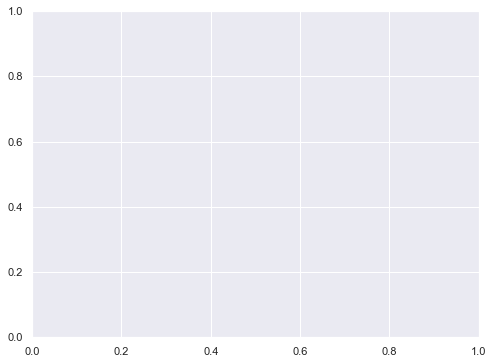

In [10]:
#now plot the function
fig, axes = plt.subplots(1, 1, figsize=(8,6))
beta_soln = solution.x[0]
rho_soln = solution.x[1]

E_grid = np.linspace(0.1, 10, 200)
f_vals = [f_dist(E*m, beta_soln, rho_soln, m, sign) for E in E_grid]
plt.semilogy()
plt.plot(E_grid, f_vals, lw=3, label=r'$f$')
plt.xlabel(r'$E/m$')
plt.tight_layout(True)